## Objective
The key objective of this project is to pass 0.85 accuracy threshold at kaggle for recognition of the provided set of captcha letters

### Goals
- use image augmentation as the train sample is rather limitted
- use transfer learning for shorter model training and better accuracy

In [ ]:
# Set up the environment 
import tensorflow as tf
import os

try:
    tf.get_logger().propagate = False
    if 'COLAB_TPU_ADDR' in os.environ: #colab
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR'])
    else: #kaggle
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    print('TPU initialized, num of accelerators:', strategy.num_replicas_in_sync)
except (ValueError, KeyError):
    print('TPU not found, using CPU/GPU')
    strategy = tf.distribute.get_strategy()

TPU not found, using CPU/GPU


In [ ]:
# Getting access to the datat
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

### Data loading and exploraton

In [ ]:
# Loaging the arrays for train images, labels and test data 
images = np.load('/content/drive/MyDrive/Colab Notebooks/CAPTCHA/images.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/CAPTCHA/labels.npy')
images_sub =np.load('/content/drive/MyDrive/Colab Notebooks/CAPTCHA/images_sub.npy')

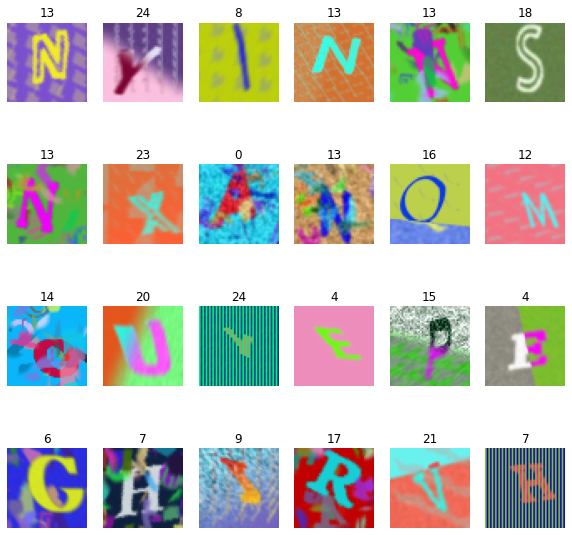

In [ ]:
# Visualization of the train images along with the labels
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(24):
  ax = plt.subplot(4,6, i + 1)
  plt.imshow(images[i])
  plt.title(int(labels[i]))
  plt.axis("off")

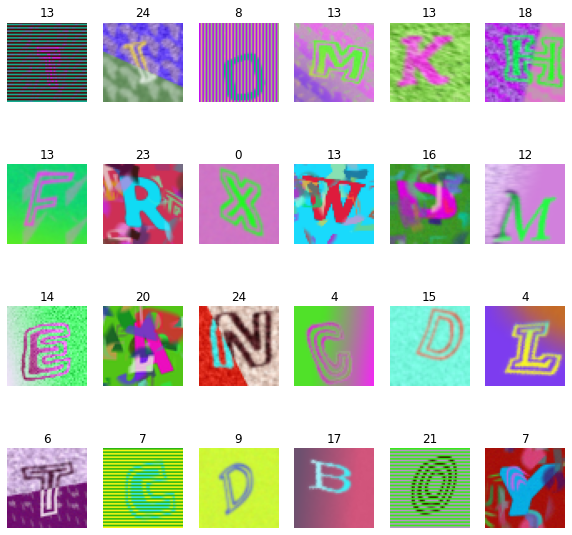

In [ ]:
# Visual exploration of the test sample
plt.figure(figsize=(10, 10))
for i in range(24):
  ax = plt.subplot(4, 6, i + 1)
  plt.imshow(images_sub[i])
  plt.title(int(labels[i]))
  plt.axis("off")

### Building a model

In [ ]:
# Preparing image generator for data augmentation
from keras.preprocessing.image import ImageDataGenerator
imagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        brightness_range=[0.7,1.0],
        channel_shift_range=3,         
        zoom_range=0.2)

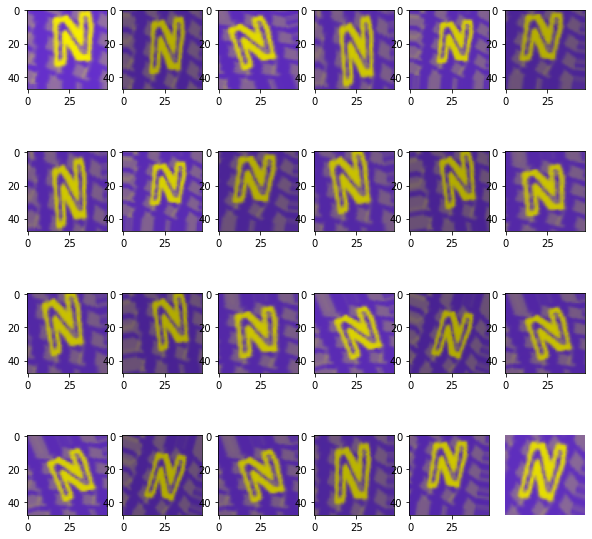

In [ ]:
# Visualizing agumented data examples
import matplotlib.pyplot as plt
vis_generator = imagen.flow(images[0:1],labels[0:1], batch_size=1)

image = []

for i in range(24):
    image.append(vis_generator.next()[0][0])

fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(10, 10))

for i in range(4):
    for j in range(6):
        ax[i][j].imshow(image[3 * i + j] / 255.)
        

In [ ]:
# Immporting one the latests verisoin of EfficientNet state-of-the-art models trained on Imagenet, without top layers and making it trainable
import tensorflow as tf
network = tf.keras.applications.EfficientNetV2M(weights = 'imagenet', include_top = False, input_shape=(48, 48, 3), classes=26, pooling='avg')
network.trainable = True


214212608/214201816 [==============================] - 2s 0us/step


In [ ]:
# Putting the model together and compiling with 'sparse cat crossentropy' for a quicker convergence
model = tf.keras.Sequential([
    network,
    tf.keras.layers.Dense(26, activation='softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = 'sparse_categorical_accuracy')

In [ ]:
traingen = imagen.flow(images, labels, batch_size=128) 

In [ ]:
history=model.fit(traingen, batch_size=128, epochs=5)

Epoch 1/5
157/157 [==============================] - 96s 609ms/step - loss: 0.2332 - sparse_categorical_accuracy: 0.9301
Epoch 2/5
157/157 [==============================] - 96s 610ms/step - loss: 0.2037 - sparse_categorical_accuracy: 0.9384
Epoch 3/5
157/157 [==============================] - 96s 612ms/step - loss: 0.1867 - sparse_categorical_accuracy: 0.9424
Epoch 4/5
157/157 [==============================] - 96s 611ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.9482
Epoch 5/5
157/157 [==============================] - 96s 612ms/step - loss: 0.1411 - sparse_categorical_accuracy: 0.9572


In [ ]:
# Evaluating the model
model.evaluate(images, labels)

625/625 [==============================] - 68s 100ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9809


[0.06056681647896767, 0.9809499979019165]

In [ ]:
# Saving the moeld for further reuse
model.save('/content/drive/MyDrive/Colab Notebooks/CAPTCHA/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CAPTCHA/assets


In [ ]:
# Making the predicitons
predictions = model.predict(images_sub).argmax(axis = 1)


In [ ]:
# Saving the predictions to submission file
submission = pd.DataFrame({'Id': list(range(len(predictions))), 'Category': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/CAPTCHA/submission.csv', index = False)

## Result
The model showed 0.97 accuracy for the test sample recognition, which is far above targeted 0.85 threshold.